In [1]:
#pip install boto3 --user
#pip install pandas-profiling[notebook] --user
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
import pandas as pd
import numpy as np
import boto3
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator
import seaborn as sns
import fun_eda, fun_s3

# Análisis exploratorio de datos

# 1. Base original

In [3]:
bucket_name = 'movicovid'
fname = '{}/{}/{}'.format('data', 'dataforgood', 'movimientos_entre_administraciones_08062020.csv')

In [4]:
original_data = fun_s3.abre_file_como_df(bucket_name, fname)
#s3.download_file(bucket_name, fname, 'movimientos_entre_administraciones_08062020.csv')

In [5]:
original_data.head()
#original_data.columns

,difference,baseline_people_moving,crisis_people_moving,percent_change,standard_z_score,starting_region_name,ending_region_name,starting_location,ending_location,length_km,geometry,start_lat,start_lon,end_lat,end_lon,hora,hr,fecha
0,3.6,61.4,65,5.769231,0.654005,Azcapotzalco,Acolman,590926,591495,25.572917,LINESTRING (-99.16310471754808 19.488262625130...,19.485337,-99.182136,19.633768,-98.919868,00:00:00,0,2020-02-27
1,-161.2,29851.2,29690,-0.539994,-0.512844,Benito Juárez,Benito Juárez,589331,589331,0.086858,LINESTRING (-99.16324373671165 19.374161793603...,19.380692,-99.161232,19.380692,-99.161232,00:00:00,0,2020-02-27
2,11.4,18.6,30,58.163265,3.468910,Benito Juárez,Nextlalpan,589331,589332,37.176444,"LINESTRING (-99.163330078125 19.3740310041428,...",19.380692,-99.161232,19.726623,-99.076491,00:00:00,0,2020-02-27
3,-0.4,11.4,11,-3.225806,-0.099075,Tultitlán,Coyotepec,589238,593432,17.062451,LINESTRING (-99.16359641335227 19.632239857166...,19.626197,-99.145332,19.787257,-99.225722,00:00:00,0,2020-02-27
4,7.8,198.2,206,3.915663,0.573158,Benito Juárez,Chicoloapan,589331,590743,27.783948,LINESTRING (-99.16366429004854 19.374044420647...,19.380692,-99.161232,19.405405,-98.878142,00:00:00,0,2020-02-27


In [6]:
####################################   CAMBIO TIPO DE VARIABLES  ####################################
original_data['starting_region_name'] = original_data['starting_region_name'].astype('category')
original_data['ending_region_name'] = original_data['ending_region_name'].astype('category')
original_data['fecha'] = pd.to_datetime(original_data['fecha'])
original_data['hr'] = original_data['hora'].str.slice(start=0, stop=2).astype(int)

In [7]:
#################################### INFORMACION GENERAL ####################################
# Informacion general de la base
# Clasificación de las variables por tipo
[numeric_variables, categorical_variables, dates_variables, string_variables] = fun_eda.info_type_of_vars(original_data)
# Imprime a pantalla las variables por tipo
fun_eda.print_info_type_of_vars(numeric_variables, categorical_variables, dates_variables, string_variables)

Numericas:
 ['difference' 'baseline_people_moving' 'crisis_people_moving'
 'percent_change' 'standard_z_score' 'starting_location' 'ending_location'
 'length_km' 'start_lat' 'start_lon' 'end_lat' 'end_lon' 'hr'] 
 Total:  13 

Categoricas:
 ['starting_region_name' 'ending_region_name'] 
 Total:  2 

Formato Fecha: 
 ['fecha'] 
 Total:  1 

Foramto texto: 
 ['geometry' 'hora'] 
 Total:  2 



 ## Estadísticas descriptivas
 
 ### a) Variables numéricas

In [8]:
fun_eda.descriptive_stats_for_numeric_vars(original_data, numeric_variables).round(2)

,difference,baseline_people_moving,crisis_people_moving,percent_change,standard_z_score,starting_location,ending_location,length_km,start_lat,start_lon,end_lat,end_lon,hr
n_observations,284495.00,284495.00,284495.00,284495.00,284495.00,284495.00,284495.00,284495.00,276116.00,276116.00,276116.00,276116.00,284495.00
max,130674.20,222605.40,221390.00,2161.90,4.00,593432.00,593432.00,82.37,19.82,-98.72,19.82,-98.72,16.00
min,-144357.00,10.00,10.00,-98.56,-4.00,589187.00,589187.00,0.00,19.12,-99.48,19.12,-99.48,0.00
mean,-5.11,2409.01,2403.90,-32.19,-1.89,590317.19,590302.83,13.45,19.47,-99.10,19.47,-99.10,7.77
std_dev,5379.22,11937.08,12489.86,40.22,2.36,1241.36,1239.51,9.30,0.16,0.14,0.16,0.14,6.68
25%,-200.20,64.20,32.00,-61.76,-4.00,589245.00,589245.00,5.39,19.35,-99.18,19.35,-99.18,0.00
median,-42.20,200.20,103.00,-37.59,-2.46,589867.00,589820.00,12.66,19.43,-99.12,19.43,-99.12,8.00
75%,-3.60,763.20,423.00,-4.24,-0.38,591201.00,591093.00,19.80,19.60,-99.00,19.60,-99.02,16.00
kurtosis,421.41,131.25,78.85,100.09,0.04,-0.18,-0.12,-0.05,-0.80,-0.19,-0.79,-0.17,-1.57
skewness,-2.62,10.08,8.15,4.16,0.96,0.98,1.00,0.60,0.17,0.40,0.18,0.42,0.05


### b) Variables categoricas

In [9]:
fun_eda.descriptive_stats_for_categorical_vars(original_data,['hora', 'starting_region_name', 'ending_region_name', 'geometry'])

,hora,starting_region_name,ending_region_name,geometry
n_observations,284495,284495,284495,284495
mode,00:00:00,Cuauhtémoc,Cuauhtémoc,LINESTRING (-99.08569335937501 19.756363895671...
num_categories,3,66,66,275890
categories,"[00:00:00, 08:00:00, 16:00:00]","[Azcapotzalco, Benito Juárez, Tultitlán, Tlalp...","[Acolman, Benito Juárez, Nextlalpan, Coyotepec...",[LINESTRING (-99.16310471754808 19.48826262513...
n_unique_values,3,66,66,275890
n_missings,0,0,0,0
%_missings,0,0,0,0
Top1_most_common,00:00:00,Cuauhtémoc,Cuauhtémoc,LINESTRING (-99.08569335937501 19.756363895671...
Top2_most_common,16:00:00,Miguel Hidalgo,Miguel Hidalgo,LINESTRING (-98.90991210937499 19.570141807849...
Top3_most_common,08:00:00,Gustavo A. Madero,Gustavo A. Madero,LINESTRING (-98.75610351562499 19.155546224916...


In [10]:
print("Primer dia:", original_data['fecha'].max(), "\nUltimo dia:", original_data['fecha'].min())
#original_data['fecha'].describe()

Primer dia: 2020-06-07 00:00:00 
Ultimo dia: 2020-02-27 00:00:00


In [11]:
#################################### PANDAS PROFILING  ####################################

#profile = ProfileReport(data, title="Pandas Profiling Report", minimal=True)
#profile.to_widgets()
#profile.to_file("~/bj/Profile_report.html")

# 2. Variables de interés

In [12]:
data = original_data[['difference', 'baseline_people_moving', 'crisis_people_moving', 'starting_region_name', 'percent_change',
                     'ending_region_name', 'length_km', 'hr','fecha']].copy()

In [13]:
data.shape

(284495, 9)

## Registros Duplicados

Set original: 284,495

Set sin duplicados: 279,062

Duplicados: 5,433

In [14]:
####################################  DROP REGISTROS DUPLICADOS
# elimina todos, menos el primero
data.drop_duplicates(subset = ['difference', 'baseline_people_moving', 'crisis_people_moving', 'starting_region_name',
                               'percent_change', 'ending_region_name', 'length_km', 'hr','fecha'], 
                              keep = 'first', inplace = True) 

In [15]:
data.shape

(279062, 9)

In [16]:
delegaciones = ["Álvaro Obregón", 
                "Azcapotzalco",
                "Benito Juárez",
                "Coyoacán",	
                "Cuajimalpa de Morelos",
                "Cuauhtémoc",
                "Gustavo A. Madero",
                "Iztacalco",
                "Iztapalapa",
                "La Magdalena Contreras",
                "Miguel Hidalgo",
                "Milpa Alta",
                "Tláhuac",
                "Tlalpan",
                "Venustiano Carranza",
                "Xochimilco"]

In [17]:
####################################   TRANSFORMACION DE VARIABLES  ####################################

#### Añado columnas que indican si el Origen/Destino es en CDMX
data = data.assign(ori_cdmx=np.where(data["starting_region_name"].isin(delegaciones), 'CDMX', 'Otro'), 
                   des_cdmx=np.where(data["ending_region_name"].isin(delegaciones), 'CDMX', 'Otro'))

### Añado una columna que contabilice el numero de semanas
data['num_semana'] = data['fecha'].dt.week

### Añado una columna para el dia de la semana
dict_days = {0:'Lunes',1:'Martes',2:'Miércoles',3:'Jueves',4:'Viernes',5:'Sábado',6:'Domingo'}
data['dia_semana'] = data['fecha'].dt.dayofweek.map(dict_days)

### Anado una columna para identificar la ruta
data['ruta'] = data['starting_region_name'].astype(str) + " - " + data['ending_region_name'].astype(str)


In [18]:
fun_eda.descriptive_stats_for_numeric_vars(original_data, numeric_variables).round(2)

,difference,baseline_people_moving,crisis_people_moving,percent_change,standard_z_score,starting_location,ending_location,length_km,start_lat,start_lon,end_lat,end_lon,hr
n_observations,284495.00,284495.00,284495.00,284495.00,284495.00,284495.00,284495.00,284495.00,276116.00,276116.00,276116.00,276116.00,284495.00
max,130674.20,222605.40,221390.00,2161.90,4.00,593432.00,593432.00,82.37,19.82,-98.72,19.82,-98.72,16.00
min,-144357.00,10.00,10.00,-98.56,-4.00,589187.00,589187.00,0.00,19.12,-99.48,19.12,-99.48,0.00
mean,-5.11,2409.01,2403.90,-32.19,-1.89,590317.19,590302.83,13.45,19.47,-99.10,19.47,-99.10,7.77
std_dev,5379.22,11937.08,12489.86,40.22,2.36,1241.36,1239.51,9.30,0.16,0.14,0.16,0.14,6.68
25%,-200.20,64.20,32.00,-61.76,-4.00,589245.00,589245.00,5.39,19.35,-99.18,19.35,-99.18,0.00
median,-42.20,200.20,103.00,-37.59,-2.46,589867.00,589820.00,12.66,19.43,-99.12,19.43,-99.12,8.00
75%,-3.60,763.20,423.00,-4.24,-0.38,591201.00,591093.00,19.80,19.60,-99.00,19.60,-99.02,16.00
kurtosis,421.41,131.25,78.85,100.09,0.04,-0.18,-0.12,-0.05,-0.80,-0.19,-0.79,-0.17,-1.57
skewness,-2.62,10.08,8.15,4.16,0.96,0.98,1.00,0.60,0.17,0.40,0.18,0.42,0.05


In [19]:
fun_eda.descriptive_stats_for_categorical_vars(original_data,['hora', 'starting_region_name', 'ending_region_name', 'geometry'])

,hora,starting_region_name,ending_region_name,geometry
n_observations,284495,284495,284495,284495
mode,00:00:00,Cuauhtémoc,Cuauhtémoc,LINESTRING (-99.08569335937501 19.756363895671...
num_categories,3,66,66,275890
categories,"[00:00:00, 08:00:00, 16:00:00]","[Azcapotzalco, Benito Juárez, Tultitlán, Tlalp...","[Acolman, Benito Juárez, Nextlalpan, Coyotepec...",[LINESTRING (-99.16310471754808 19.48826262513...
n_unique_values,3,66,66,275890
n_missings,0,0,0,0
%_missings,0,0,0,0
Top1_most_common,00:00:00,Cuauhtémoc,Cuauhtémoc,LINESTRING (-99.08569335937501 19.756363895671...
Top2_most_common,16:00:00,Miguel Hidalgo,Miguel Hidalgo,LINESTRING (-98.90991210937499 19.570141807849...
Top3_most_common,08:00:00,Gustavo A. Madero,Gustavo A. Madero,LINESTRING (-98.75610351562499 19.155546224916...


In [20]:
print("Primer dia:", original_data['fecha'].min(), "\nUltimo dia:", original_data['fecha'].max())
original_data['fecha'].describe()

Primer dia: 2020-02-27 00:00:00 
Ultimo dia: 2020-06-07 00:00:00


count                  284495
unique                    102
top       2020-03-02 00:00:00
freq                     4216
first     2020-02-27 00:00:00
last      2020-06-07 00:00:00
Name: fecha, dtype: object

In [21]:
original_data['hora'].describe()

count       284495
unique           3
top       00:00:00
freq        103471
Name: hora, dtype: object

In [22]:
data.head()
#data.shape
# 279,062 rows × 14 columns

,difference,baseline_people_moving,crisis_people_moving,starting_region_name,percent_change,ending_region_name,length_km,hr,fecha,ori_cdmx,des_cdmx,num_semana,dia_semana,ruta
0,3.6,61.4,65,Azcapotzalco,5.769231,Acolman,25.572917,0,2020-02-27,CDMX,Otro,9,Jueves,Azcapotzalco - Acolman
1,-161.2,29851.2,29690,Benito Juárez,-0.539994,Benito Juárez,0.086858,0,2020-02-27,CDMX,CDMX,9,Jueves,Benito Juárez - Benito Juárez
2,11.4,18.6,30,Benito Juárez,58.163265,Nextlalpan,37.176444,0,2020-02-27,CDMX,Otro,9,Jueves,Benito Juárez - Nextlalpan
3,-0.4,11.4,11,Tultitlán,-3.225806,Coyotepec,17.062451,0,2020-02-27,Otro,Otro,9,Jueves,Tultitlán - Coyotepec
4,7.8,198.2,206,Benito Juárez,3.915663,Chicoloapan,27.783948,0,2020-02-27,CDMX,Otro,9,Jueves,Benito Juárez - Chicoloapan


## Original Baseline

Tomando el baseline original de la fuente, por ruta (origen-destino) dia de la semana y hora, se tienen 23,959 registros distintos. De este total, en 35 casos el baseline *no es único*. Esto representa 0.14%.

Por ahora, consideraremos este baseline para el análisis.

In [23]:
baseline = data.groupby(['ruta', 'dia_semana', 'hr']).nunique()['baseline_people_moving']
baseline = baseline.reset_index()  

In [24]:
#len(baseline)
#baseline

In [25]:
baseline_inconsistente  = baseline[(baseline['baseline_people_moving']!=1)]
baseline_inconsistente.shape

(35, 4)

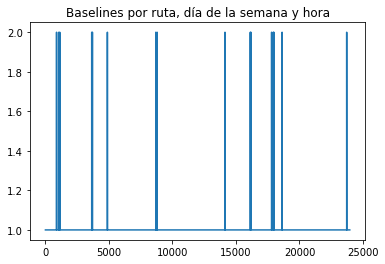

In [26]:
plt.plot(baseline['baseline_people_moving']) 
plt.title("Baselines por ruta, día de la semana y hora")
plt.show()

In [27]:
baseline_inconsistente

,ruta,dia_semana,hr,baseline_people_moving
869,Atizapán de Zaragoza - Iztapalapa,Domingo,0,2
870,Atizapán de Zaragoza - Iztapalapa,Domingo,8,2
875,Atizapán de Zaragoza - Iztapalapa,Lunes,0,2
876,Atizapán de Zaragoza - Iztapalapa,Lunes,8,2
877,Atizapán de Zaragoza - Iztapalapa,Lunes,16,2
1043,Atizapán de Zaragoza - Tlalpan,Domingo,0,2
1045,Atizapán de Zaragoza - Tlalpan,Domingo,16,2
1049,Atizapán de Zaragoza - Tlalpan,Lunes,8,2
1050,Atizapán de Zaragoza - Tlalpan,Lunes,16,2
1127,Atizapán de Zaragoza - Álvaro Obregón,Domingo,0,2


In [28]:
data[(data['starting_region_name']=='Atizapán de Zaragoza') & (data['ending_region_name']=='Iztapalapa') 
          & (data['hr']==0) & (data['dia_semana']=='Domingo')].sort_values(['fecha','hr'])

,difference,baseline_people_moving,crisis_people_moving,starting_region_name,percent_change,ending_region_name,length_km,hr,fecha,ori_cdmx,des_cdmx,num_semana,dia_semana,ruta
10378,0.6,14.4,15,Atizapán de Zaragoza,3.896104,Iztapalapa,27.100748,0,2020-03-01,Otro,CDMX,9,Domingo,Atizapán de Zaragoza - Iztapalapa
49943,-2.4,14.4,12,Atizapán de Zaragoza,-15.584416,Iztapalapa,25.916037,0,2020-03-15,Otro,CDMX,11,Domingo,Atizapán de Zaragoza - Iztapalapa
131691,-3105.2,5975.2,2870,Atizapán de Zaragoza,-51.959439,Iztapalapa,26.060411,0,2020-04-05,Otro,CDMX,14,Domingo,Atizapán de Zaragoza - Iztapalapa


In [29]:
original_data[(original_data['starting_region_name']=='Atizapán de Zaragoza') & (original_data['ending_region_name']=='Iztapalapa') 
          & (original_data['fecha']=='2020-04-05') & (original_data['hr']==0)]
# Otros domingos
# 2020-03-01 , 2020-04-05 

,difference,baseline_people_moving,crisis_people_moving,percent_change,standard_z_score,starting_region_name,ending_region_name,starting_location,ending_location,length_km,geometry,start_lat,start_lon,end_lat,end_lon,hora,hr,fecha
131691,-3105.2,5975.2,2870,-51.959439,-2.503942,Atizapán de Zaragoza,Iztapalapa,591219,589187,26.060411,"LINESTRING (-99.228515625 19.55976887025072, -...",NaN,NaN,NaN,NaN,00:00:00,0,2020-04-05
131694,-3105.2,5975.2,2870,-51.959439,-2.503942,Atizapán de Zaragoza,Iztapalapa,591219,589187,26.060411,"LINESTRING (-99.228515625 19.55976887025072, -...",NaN,NaN,NaN,NaN,00:00:00,0,2020-04-05
131697,-3105.2,5975.2,2870,-51.959439,-2.503942,Atizapán de Zaragoza,Iztapalapa,591219,589187,26.060411,"LINESTRING (-99.228515625 19.55976887025072, -...",NaN,NaN,NaN,NaN,00:00:00,0,2020-04-05


In [30]:
baseline_inconsistente = baseline_inconsistente['ruta']

## Rutas

Las rutas con origen y destino fuera de la CDMX representan el 40% de las rutas en la base, mientras que las que tienen origen y destino en la CDMX son el 23.7%.

La distribución de las rutas por hora, según su origen destino, se mantiene casi constante a lo largo de las 3 ventanas de tiempo para las rutas con origen y destino fuera de la CDMX.

Para las rutas con origen y destino en la CDMX, también se mantuvieron relativamente constantes a lo largo del día.

Las rutas con origen fuera de la CDMX y destino en la CDMX concentraron el 22% y 20% a las 8 y 16 horas, pero disminuyeron hasta 14% para las 00 horas. Inversamente, las rutas con origen en la CDMX y destino fuera de la CDMX aumentaron a 23% a las 00 horas, de 13% y 16% a las 8 y 6 horas.


In [31]:
total_rutas = len(data)
rutas = data.groupby(['ori_cdmx', 'des_cdmx']).size()
rutas = rutas.reset_index()  
rutas.columns = ['Origen', 'Destino', 'Rutas']
rutas = rutas.pivot_table(index='Origen', columns='Destino', values='Rutas')
rutas_prop = rutas.divide(total_rutas) * 100

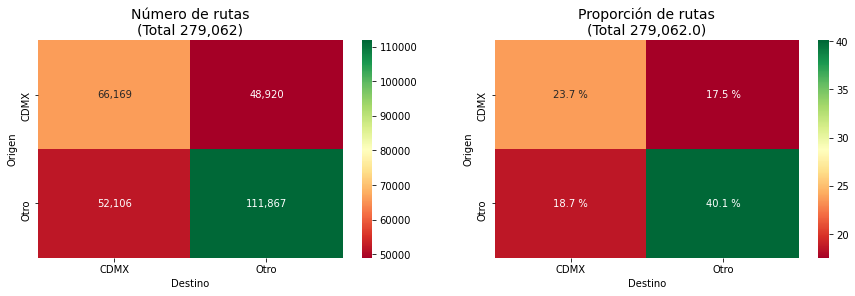

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.heatmap( rutas, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[0])
ax[0].set_title('Número de rutas\n(Total {:0,.0f})'.format(total_rutas), fontsize=14)

sns.heatmap( rutas_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('Proporción de rutas\n(Total {:0,.1f})'.format(total_rutas), fontsize=14)
for t in ax[1].texts: t.set_text(t.get_text() + " %")


plt.show()

In [33]:
ruta_hora = data.groupby(['ori_cdmx', 'des_cdmx', 'hr']).size()
ruta_hora = ruta_hora.reset_index()  
ruta_hora.columns = ['Origen', 'Destino', 'hr', 'Rutas']

ruta0 = ruta_hora[ruta_hora['hr']==0].pivot_table(index='Origen', columns='Destino', values='Rutas')
ruta8 = ruta_hora[ruta_hora['hr']==8].pivot_table(index='Origen', columns='Destino', values='Rutas')
ruta16 = ruta_hora[ruta_hora['hr']==16].pivot_table(index='Origen', columns='Destino', values='Rutas')

ruta0_prop = ruta0.divide(ruta0.values.sum())*100
ruta8_prop = ruta8.divide(ruta8.values.sum())*100
ruta16_prop = ruta16.divide(ruta16.values.sum())*100

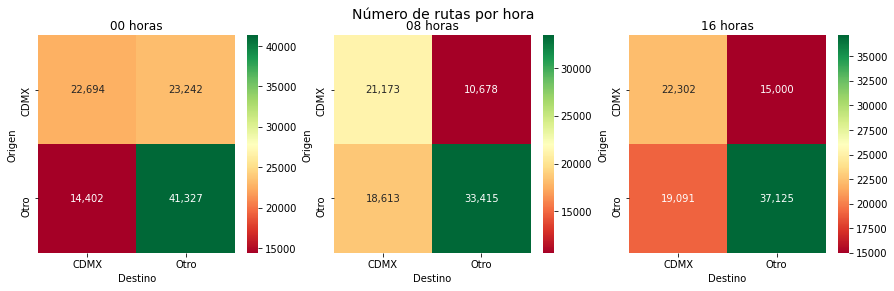

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap( ruta0, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[0])
ax[0].set_title('00 horas')

sns.heatmap( ruta8, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('08 horas')
#ax[1].set_yticklabels(())
#ax[1].set_ylabel("")

sns.heatmap( ruta16, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[2])
ax[2].set_title('16 horas')
#ax[2].set_yticklabels(())
#ax[2].set_ylabel("")

fig.suptitle('Número de rutas por hora', fontsize=14)
plt.show()
#plt.tight_layout()


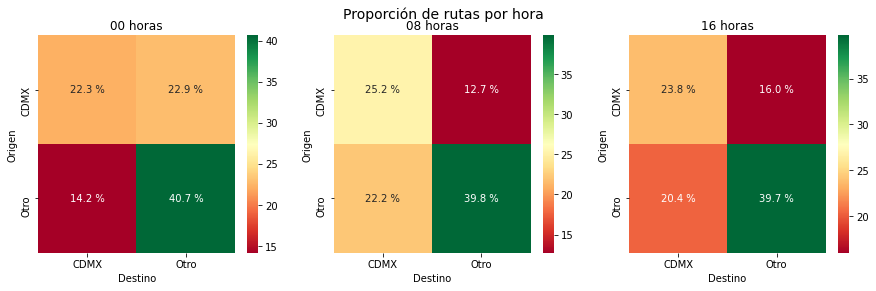

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap( ruta0_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[0])
ax[0].set_title('00 horas')
for t in ax[0].texts: t.set_text(t.get_text() + " %")

sns.heatmap( ruta8_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('08 horas')
for t in ax[1].texts: t.set_text(t.get_text() + " %")

sns.heatmap( ruta16_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[2])
ax[2].set_title('16 horas')
for t in ax[2].texts: t.set_text(t.get_text() + " %")

fig.suptitle('Proporción de rutas por hora', fontsize=14)
plt.show()
#plt.tight_layout()

# Número de personas transitando las rutas

En términos del número de personas que transitan las rutas el 95% se reparte entre rutas con origen y destino en la CDMX y, rutas con origen y destino fuera de la CDMX. El restante 5% de las personas que transitan, lo hace de municipios fuera de la CDMX a las alcaldías de la CDMX o viceversa.

In [36]:
ruta_hora = data.groupby(['ori_cdmx', 'des_cdmx', 'hr']).sum()['crisis_people_moving']
ruta_hora = ruta_hora.reset_index()  
ruta_hora.columns = ['Origen', 'Destino', 'hr', 'Rutas']

ruta0 = ruta_hora[ruta_hora['hr']==0].pivot_table(index='Origen', columns='Destino', values='Rutas')
ruta8 = ruta_hora[ruta_hora['hr']==8].pivot_table(index='Origen', columns='Destino', values='Rutas')
ruta16 = ruta_hora[ruta_hora['hr']==16].pivot_table(index='Origen', columns='Destino', values='Rutas')

ruta0_prop = ruta0.divide(ruta0.values.sum())*100
ruta8_prop = ruta8.divide(ruta8.values.sum())*100
ruta16_prop = ruta16.divide(ruta16.values.sum())*100

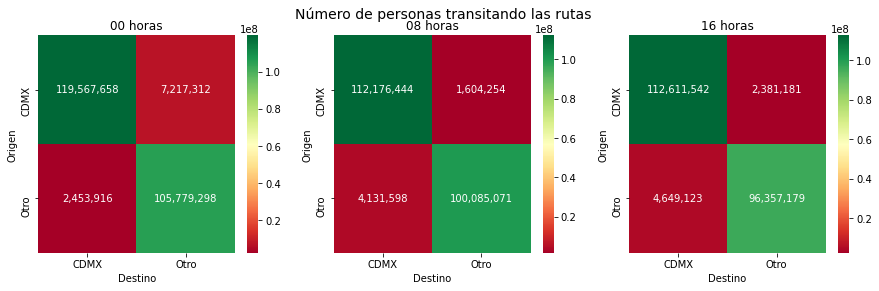

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

sns.heatmap( ruta0, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[0])
ax[0].set_title('00 horas')

sns.heatmap( ruta8, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('08 horas')

sns.heatmap( ruta16, annot=True, fmt='0,.0f', cmap='RdYlGn', ax=ax[2])
ax[2].set_title('16 horas')

fig.suptitle('Número de personas transitando las rutas',fontsize=14)
plt.show()

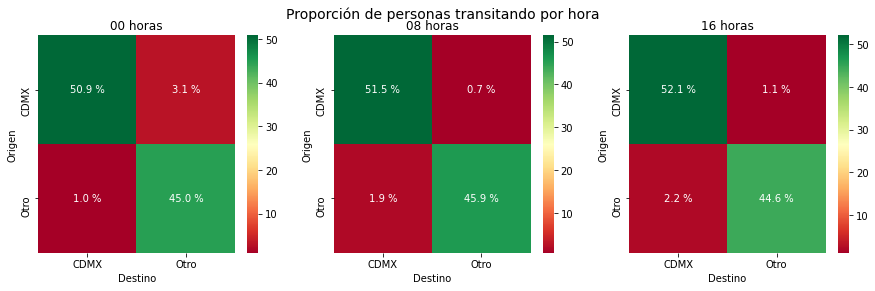

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap( ruta0_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[0])
ax[0].set_title('00 horas')
for t in ax[0].texts: t.set_text(t.get_text() + " %")

sns.heatmap( ruta8_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('08 horas')
for t in ax[1].texts: t.set_text(t.get_text() + " %")

sns.heatmap( ruta16_prop, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax[2])
ax[2].set_title('16 horas')
for t in ax[2].texts: t.set_text(t.get_text() + " %")

fig.suptitle('Proporción de personas transitando por hora', fontsize=14)
plt.show()

## Rutas únicas

Existen 1,571 rutas únicas en la base. 

Considerando las ventanas de tiempo, hay 1,438 ruta únicas a las 00 horas, 1,206 a las 08 horas y 1,316 las 16 horas.

In [39]:
print("Existen {:,.0f} rutas únicas". format(len(data['ruta'].unique())))

Existen 1,571 rutas únicas


In [40]:
print("{:,.0f} rutas unicas a las 00 horas".format(len(data[data['hr']==0]['ruta'].unique())))
print("{:,.0f} rutas unicas a las 08 horas".format(len(data[data['hr']==8]['ruta'].unique())))
print("{:,.0f} rutas unicas a las 16 horas".format(len(data[data['hr']==16]['ruta'].unique())))

1,438 rutas unicas a las 00 horas
1,206 rutas unicas a las 08 horas
1,316 rutas unicas a las 16 horas


## Distribución de rutas



In [41]:
x = data.groupby(['ruta']).size().sort_values(ascending=False)

In [42]:
bins = [0, 10, 20, 50, 100, 150, 200, 250, 300, 350]
x.groupby(pd.cut(x, bins, right = False)).count()

[0, 10)       191
[10, 20)       51
[20, 50)      133
[50, 100)     190
[100, 150)    106
[150, 200)    108
[200, 250)    111
[250, 300)    169
[300, 350)    512
dtype: int64

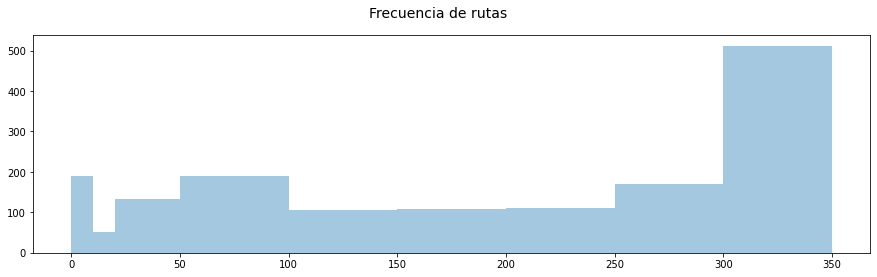

In [43]:
fig, ax = plt.subplots( figsize=(15, 4))
ax = sns.distplot(x, bins, kde=False)
fig.suptitle('Frecuencia de rutas', fontsize=14)
plt.show()

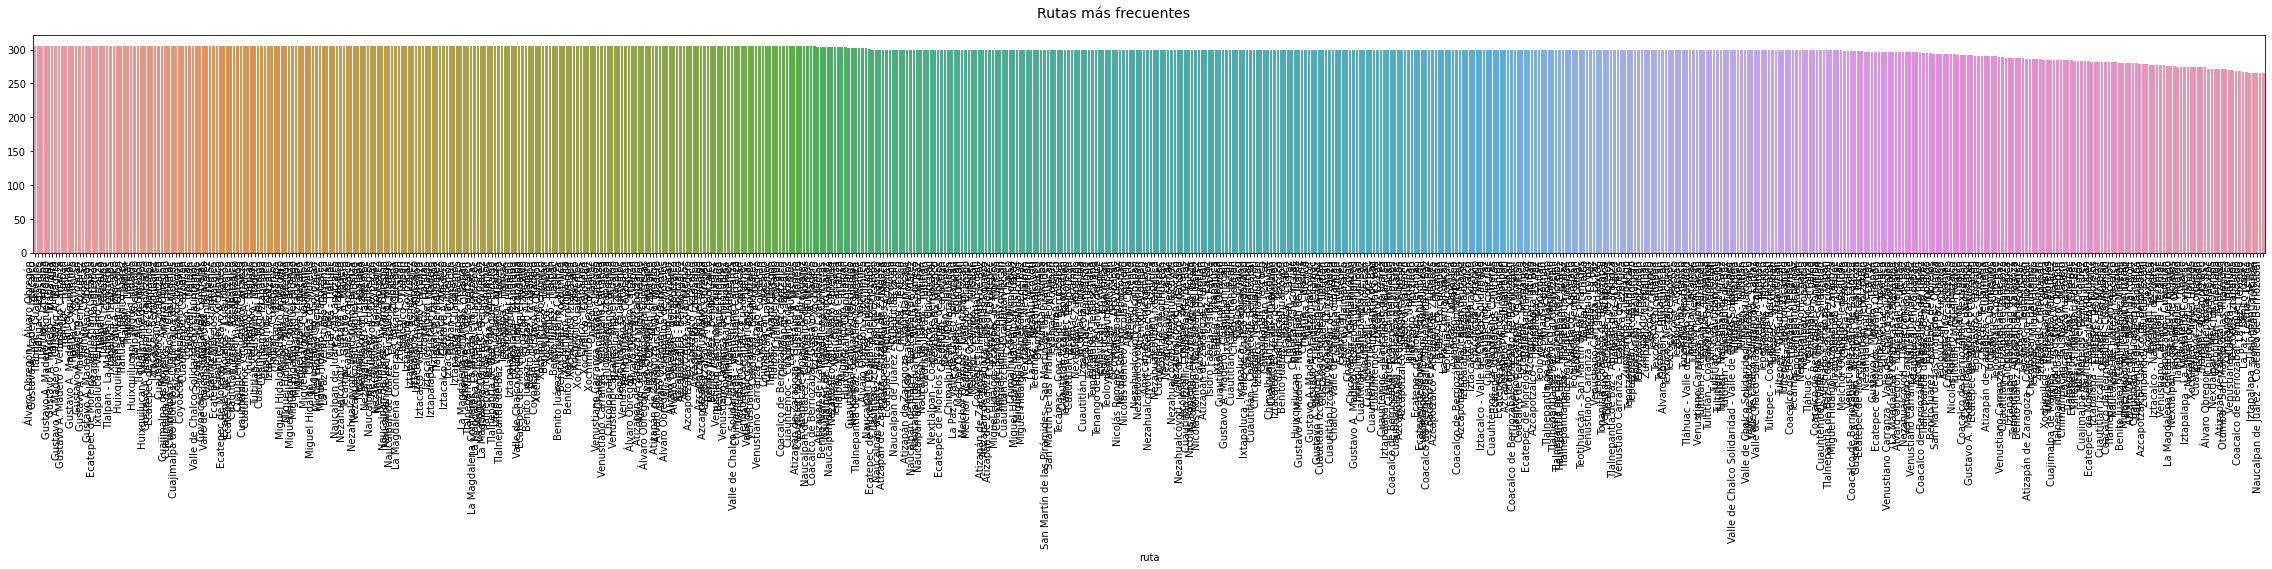

In [44]:
x = x.head(650)

fig, ax = plt.subplots(figsize=(40, 4))

ax = sns.barplot(x=x.index, y=x)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
fig.suptitle('Rutas más frecuentes', fontsize=14)

plt.show()

## Top 100 routes per people 

Las 100 rutas más transitadas durante la “crisis” transportaron al 92% de las personas que  se movieron. Las principales rutas, nuevamente, se encontraron dentro de la CDMX y entre municipios fuera de la CDMX.

Las 100 rutas más transitadas a lo largo del periodo y aún durante la "crisis", se presentan a continuación.

In [45]:
top_100 = data.groupby(['ruta']).sum()[['baseline_people_moving','crisis_people_moving']].sort_values(['crisis_people_moving'], ascending=False).head(100)

In [46]:
top_100.round(0).style.format('{:,}')

,baseline_people_moving,crisis_people_moving
ruta,,
Iztapalapa - Iztapalapa,"38,996,799.0","45,077,294"
Ecatepec de Morelos - Ecatepec de Morelos,"36,587,007.0","42,733,664"
Benito Juárez - Benito Juárez,"9,417,918.0","39,081,700"
Gustavo A. Madero - Gustavo A. Madero,"28,477,557.0","32,114,266"
Cuauhtémoc - Cuauhtémoc,"63,314,267.0","30,362,711"
Nezahualcóyotl - Nezahualcóyotl,"25,163,239.0","29,701,081"
Álvaro Obregón - Álvaro Obregón,"22,145,233.0","24,452,763"
Naucalpan de Juárez - Naucalpan de Juárez,"20,582,768.0","23,152,784"
Tlalpan - Tlalpan,"17,621,087.0","20,134,113"


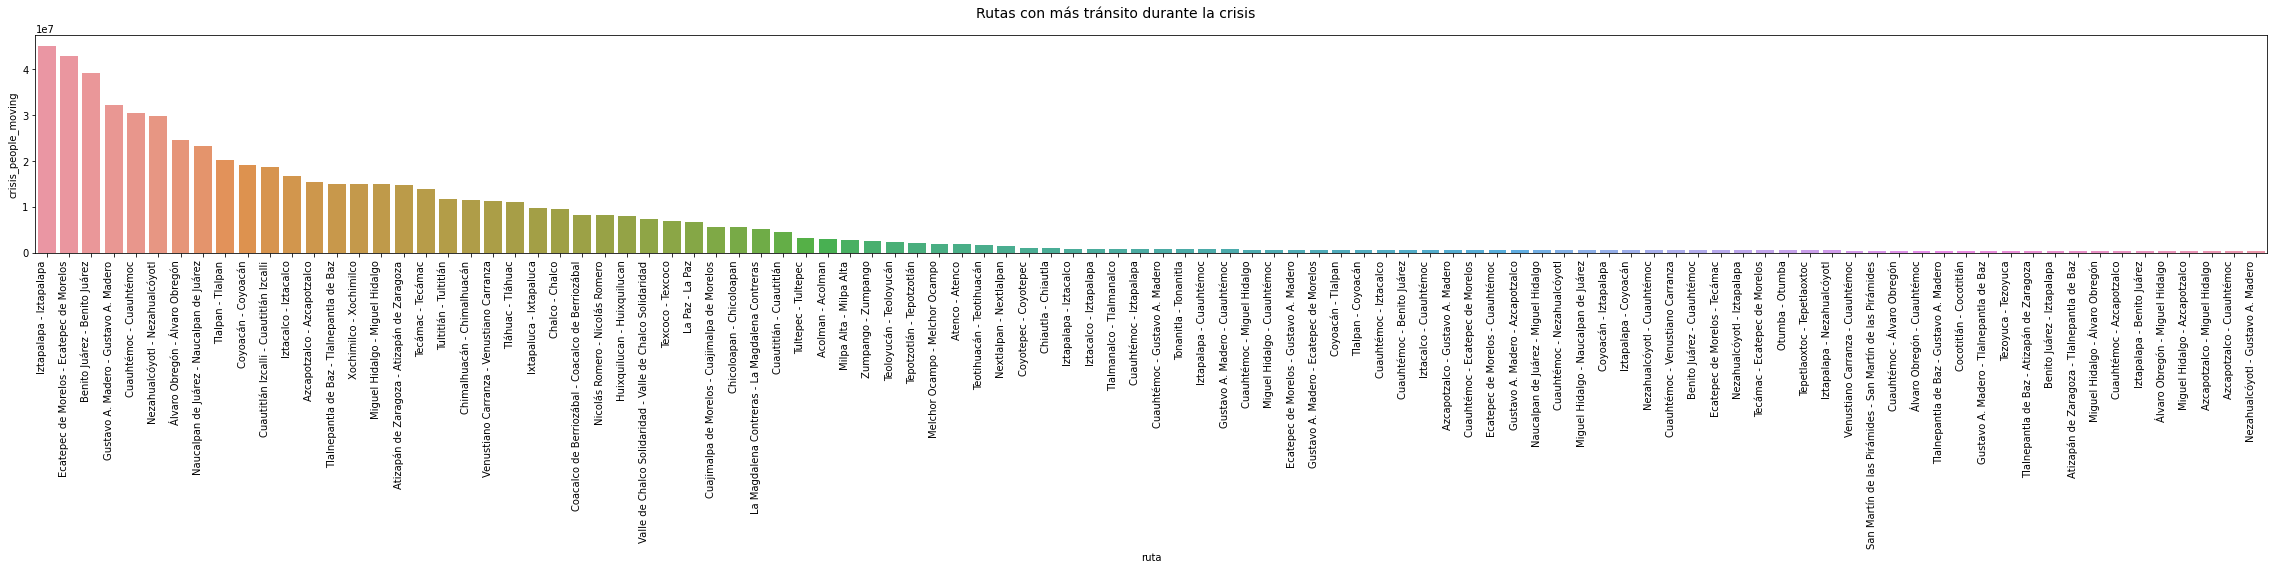

In [47]:
fig, ax = plt.subplots(figsize=(40, 4))

ax = sns.barplot(x=top_100.index, y=top_100['crisis_people_moving'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
fig.suptitle('Rutas con más tránsito durante la crisis', fontsize=14)
plt.show()

In [48]:
top_100['crisis_people_moving'].sum()/data['crisis_people_moving'].sum()

0.9187964403932508

In [49]:
# Origen - Destino de las 100 rutas más transitadas durante la "crisis"
ori_des = pd.DataFrame(top_100.index.str.split(' - ', expand=True).to_list(), columns = ['mun_origen','mun_destino'])
top_100 = top_100.assign(Origen=np.where(ori_des["mun_origen"].isin(delegaciones), 'CDMX', 'Otro'), 
                         Destino=np.where(ori_des["mun_destino"].isin(delegaciones), 'CDMX', 'Otro'))

In [50]:
top_100 = top_100.pivot_table(index='Origen', columns='Destino', values='crisis_people_moving')
top_100 = top_100.divide(top_100.values.sum())*100

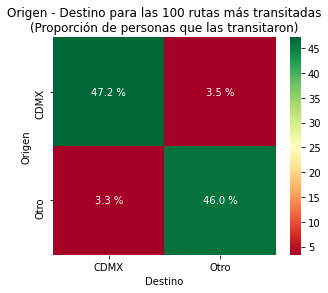

In [51]:
fig, ax = plt.subplots(figsize=(5, 4))

sns.heatmap( top_100, annot=True, fmt='0,.1f', cmap='RdYlGn', ax=ax)
for t in ax.texts: t.set_text(t.get_text() + " %")

plt.title('Origen - Destino para las 100 rutas más transitadas\n(Proporción de personas que las transitaron)', fontsize=12)
plt.show()

# Distribución de las longitudes de las rutas

El 76% de las rutas consideradas tuvieron una longitud menor a 20 km.

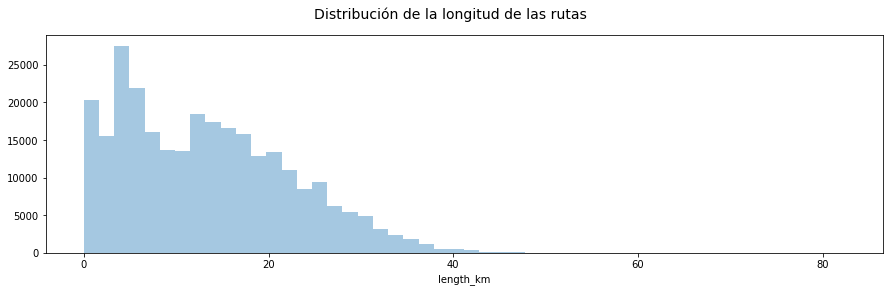

In [52]:
fig, ax = plt.subplots(figsize=(15, 4))
ax = sns.distplot(data['length_km'], kde=False)
fig.suptitle('Distribución de la longitud de las rutas', fontsize=14)
plt.show()

In [53]:
# Porcentaje de rutas con longitud menor o igual a 20 km
(data[data['length_km']<=20]['length_km'].count()/len(data))*100

75.82006865857767

# Rutas constantes

Tomamos como baseline el original de la base.

In [54]:
df_cambio = data[['ruta', 'fecha', 'percent_change']]
df_cambio = df_cambio.pivot_table(index='ruta', columns='fecha', values='percent_change')

In [55]:
#df_cambio

In [56]:
ori_des = pd.DataFrame(df_cambio.index.str.split(' - ', expand=True).to_list(), columns = ['mun_origen','mun_destino'])
df_cambio = df_cambio.assign(Origen=np.where(ori_des["mun_origen"].isin(delegaciones), 'CDMX', 'Otro'), 
                             Destino=np.where(ori_des["mun_destino"].isin(delegaciones), 'CDMX', 'Otro'))

In [57]:
#pd.concat([df_cambio, ori_des[['Origen', 'Destino']]], axis=1)
df_cambio

fecha,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,...,2020-05-31 00:00:00,2020-06-01 00:00:00,2020-06-02 00:00:00,2020-06-03 00:00:00,2020-06-04 00:00:00,2020-06-05 00:00:00,2020-06-06 00:00:00,2020-06-07 00:00:00,Origen,Destino
ruta,,,,,,,,,,,,,,,,,,,,,
Acolman - Acolman,-2.035522,-1.287425,-1.209369,-1.851896,NaN,1.624456,0.183854,-0.954920,-0.990862,-0.105634,...,21.756063,21.709619,25.614208,28.101294,27.310061,27.985538,25.116160,20.444201,Otro,Otro
Acolman - Atenco,0.220156,1.166666,4.090315,-3.420523,NaN,5.979705,18.556614,6.735911,4.974132,3.853733,...,-20.734946,-16.735120,-31.119519,-25.609185,-31.794881,-18.282892,-9.521514,-8.157293,Otro,Otro
Acolman - Azcapotzalco,17.248062,3.334315,15.384615,NaN,-18.406593,-31.031501,14.272809,1.887740,-6.752070,100.000000,...,NaN,-46.520147,-46.659654,-43.902439,-50.599340,-45.355191,38.461538,NaN,Otro,CDMX
Acolman - Benito Juárez,-14.634146,64.705882,NaN,NaN,9.523810,39.175258,-25.000000,21.951220,11.764706,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Otro,CDMX
Acolman - Chiautla,10.495283,-4.017857,19.686520,-15.492958,NaN,-38.144330,8.097166,3.773585,-37.500000,80.188088,...,40.845070,2.846209,-5.797101,NaN,NaN,-41.964286,-10.344828,-22.535211,Otro,Otro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Álvaro Obregón - Tultitlán,15.025907,-9.375000,-10.371319,-18.750000,NaN,NaN,-2.066929,-0.518135,1.310484,-1.664533,...,-77.083333,NaN,-77.188656,-77.362205,-80.310881,-86.895161,-79.513444,-64.583333,CDMX,Otro
Álvaro Obregón - Valle de Chalco Solidaridad,-2.206836,51.296507,12.586001,-1.785714,NaN,12.068966,-22.772170,14.551933,-2.212702,22.732006,...,-58.376536,NaN,-43.543061,-66.666667,-19.515618,-44.331302,-60.905603,-30.592358,CDMX,Otro
Álvaro Obregón - Venustiano Carranza,-3.174208,2.643297,-6.461919,0.923362,-0.291832,5.455269,0.291049,-3.489509,-2.509754,9.407454,...,-77.144570,-72.841718,-78.423552,-77.026561,-76.538460,-75.963748,-74.583288,-73.802771,CDMX,CDMX


In [96]:
# Porcentaje de NaN por ruta
df_nan = (df_cambio.isnull().sum(axis=1)/102)*100
df_nan[df_nan.values>50]

ruta
Acolman - Benito Juárez                  79.411765
Acolman - San Martín de las Pirámides    99.019608
Acolman - Tultitlán                      95.098039
Acolman - Venustiano Carranza            55.882353
Amecameca - Tlalmanalco                  83.333333
                                           ...    
Álvaro Obregón - Teoloyucán              98.039216
Álvaro Obregón - Teotihuacán             98.039216
Álvaro Obregón - Tepotzotlán             96.078431
Álvaro Obregón - Texcoco                 81.372549
Álvaro Obregón - Tultepec                79.411765
Length: 437, dtype: float64

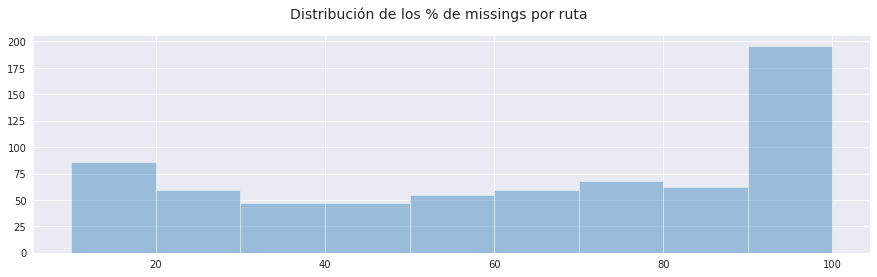

In [99]:
fig, ax = plt.subplots(figsize=(15, 4))
ax = sns.distplot(df_nan, bins=[10,20,30,40,50,60,70,80,90,100], kde=False)
fig.suptitle('Distribución de los % de missings por ruta', fontsize=14)
plt.show()

## 1. Rutas CDMX -> CDMX

Tenemos 248 rutas con origen y destino en alguna alcaldía de la CDMX.

In [58]:
cdmx_cdmx = df_cambio.loc[(df_cambio['Origen']=='CDMX') & (df_cambio['Destino']=='CDMX')].copy()
cdmx_cdmx.drop(['Origen', 'Destino'], axis=1, inplace=True)

In [59]:
#cdmx_cdmx.shape

In [60]:
#cdmx_cdmx.loc['Azcapotzalco - Azcapotzalco'].describe()
#cdmx_cdmx

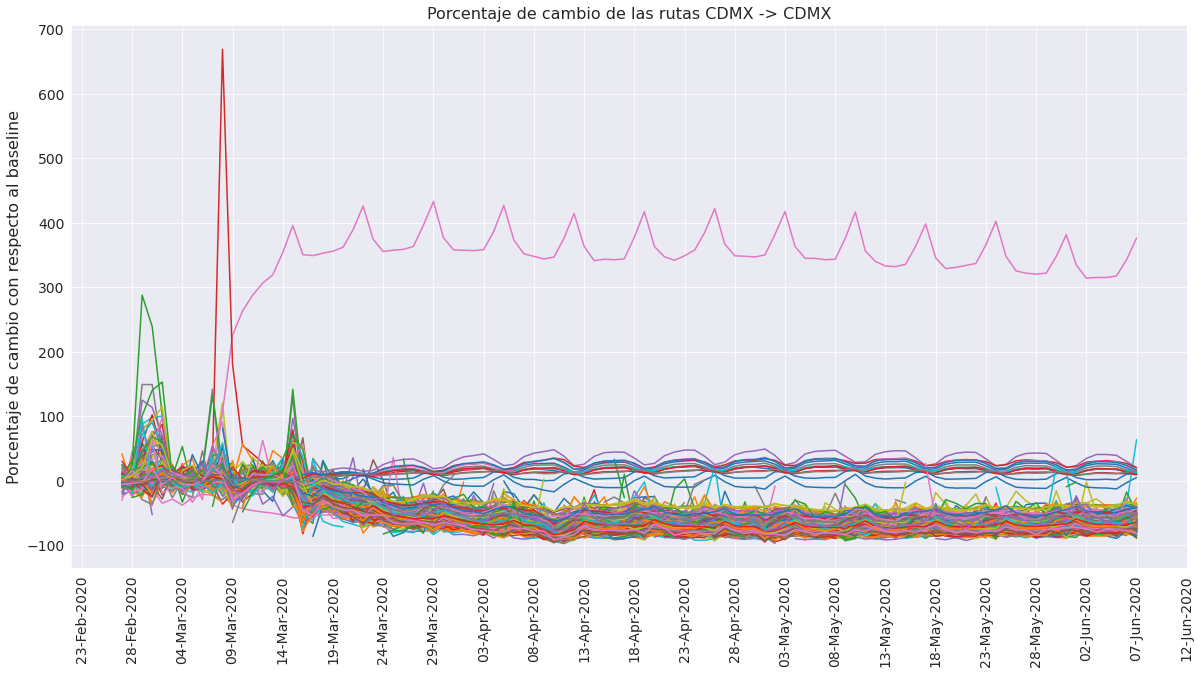

In [61]:
rutas = cdmx_cdmx.index
dias = cdmx_cdmx.columns

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas: 
    ax.plot(cdmx_cdmx.loc[ruta])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas CDMX -> CDMX', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()



In [62]:
# Rutas sin 'Benito Juárez - Benito Juárez'
cdmx_cdmx_avg_change = cdmx_cdmx.loc[cdmx_cdmx.index != 'Benito Juárez - Benito Juárez']
cdmx_cdmx_avg_change = cdmx_cdmx_avg_change.mean(axis=1, skipna=True)

In [63]:
cdmx_cdmx_avg_change.describe()

count    247.000000
mean     -44.920996
std       18.562950
min      -67.155991
25%      -56.510508
50%      -49.614906
75%      -41.166508
max       28.197069
dtype: float64

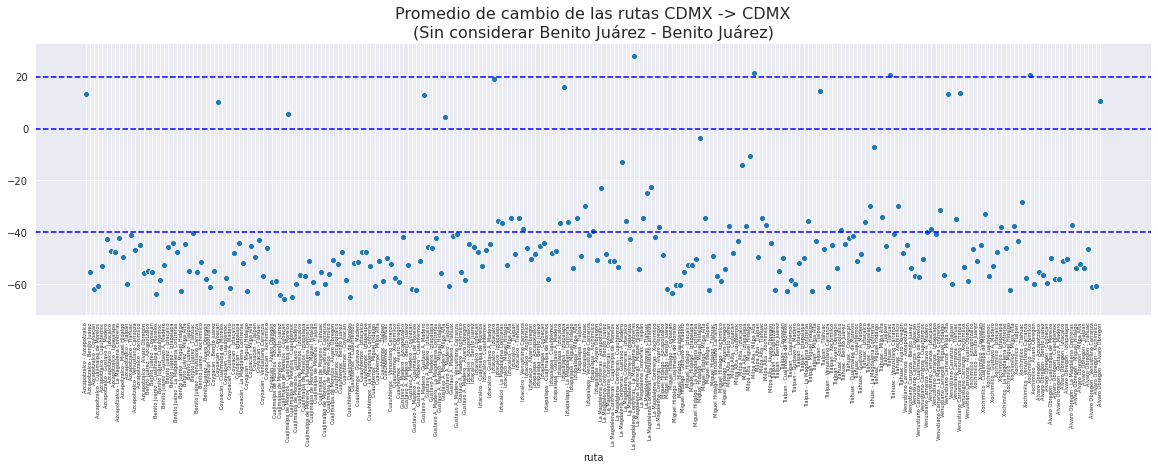

In [64]:
fig, ax = plt.subplots(figsize=(20,5))

ax = sns.scatterplot(x=cdmx_cdmx_avg_change.index, y=cdmx_cdmx_avg_change )
plt.axhline(y=-40, color='blue', linestyle='dashed')
plt.axhline(y=0, color='blue', linestyle='dashed')
plt.axhline(y=20, color='blue', linestyle='dashed')

plt.title('Promedio de cambio de las rutas CDMX -> CDMX\n(Sin considerar Benito Juárez - Benito Juárez)', fontsize='16')
plt.xticks(fontsize='5', rotation='vertical')
plt.show()

Podemos dividir las rutas según su promedio de cambio en el periodo, en los siguientes intervalos:

| Grupo | Intevalo | No. Rutas |
|:-----:|:--------:|:---------:|
|Grupo 1|[-100, -40)| 191 |
|Grupo 2|[-40, 0)| 41 |
|Grupo 3|[0, 20)| 11 |
|Grupo 4|[20, 500)| 4 |

El caso de 'Benito Juárez - Benito Juárez' se estudiara por separado.

In [65]:
bins = [-100, -40, 0, 20, 500]
grupos = pd.cut(cdmx_cdmx_avg_change, bins, right = False)

In [66]:
index_grupo1 =  grupos[grupos == grupos.cat.categories[0]].index
grupo1 = cdmx_cdmx.loc[index_grupo1]

index_grupo2 =  grupos[grupos == grupos.cat.categories[1]].index
grupo2 = cdmx_cdmx.loc[index_grupo2]

index_grupo3 =  grupos[grupos == grupos.cat.categories[2]].index
grupo3 = cdmx_cdmx.loc[index_grupo3]

index_grupo4 =  grupos[grupos == grupos.cat.categories[3]].index
grupo4 = cdmx_cdmx.loc[index_grupo4]


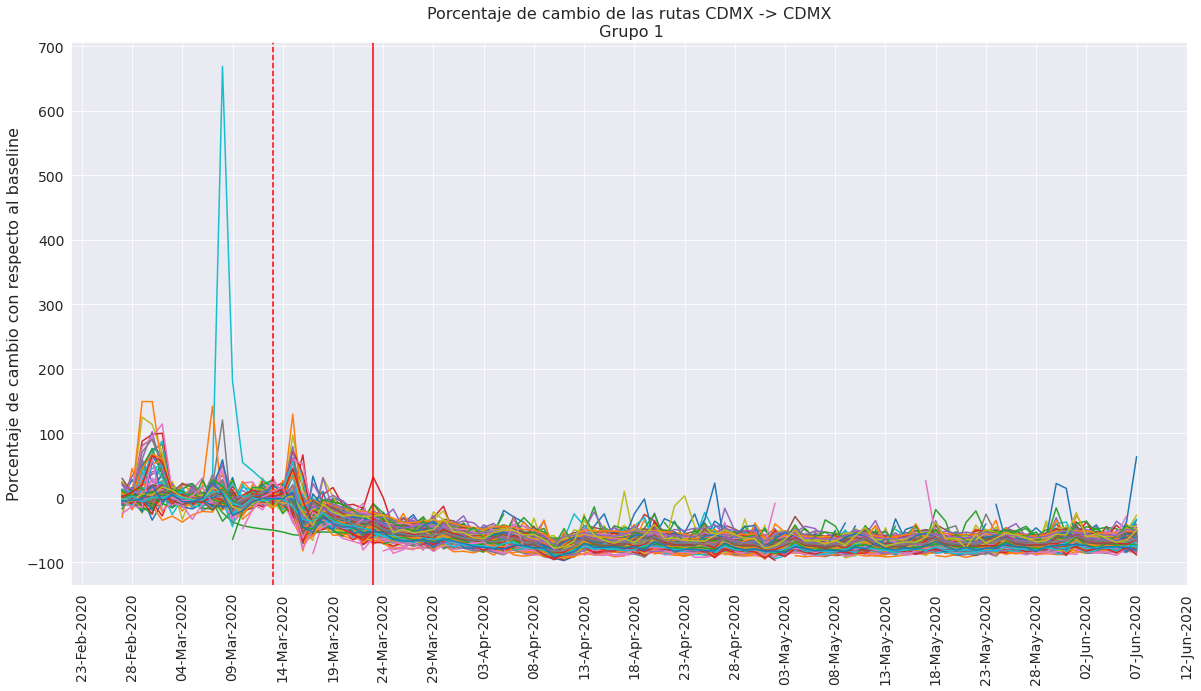

In [67]:
rutas = grupo1.index
dias = grupo1.columns

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo1.loc[ruta])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas CDMX -> CDMX\n Grupo 1', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()


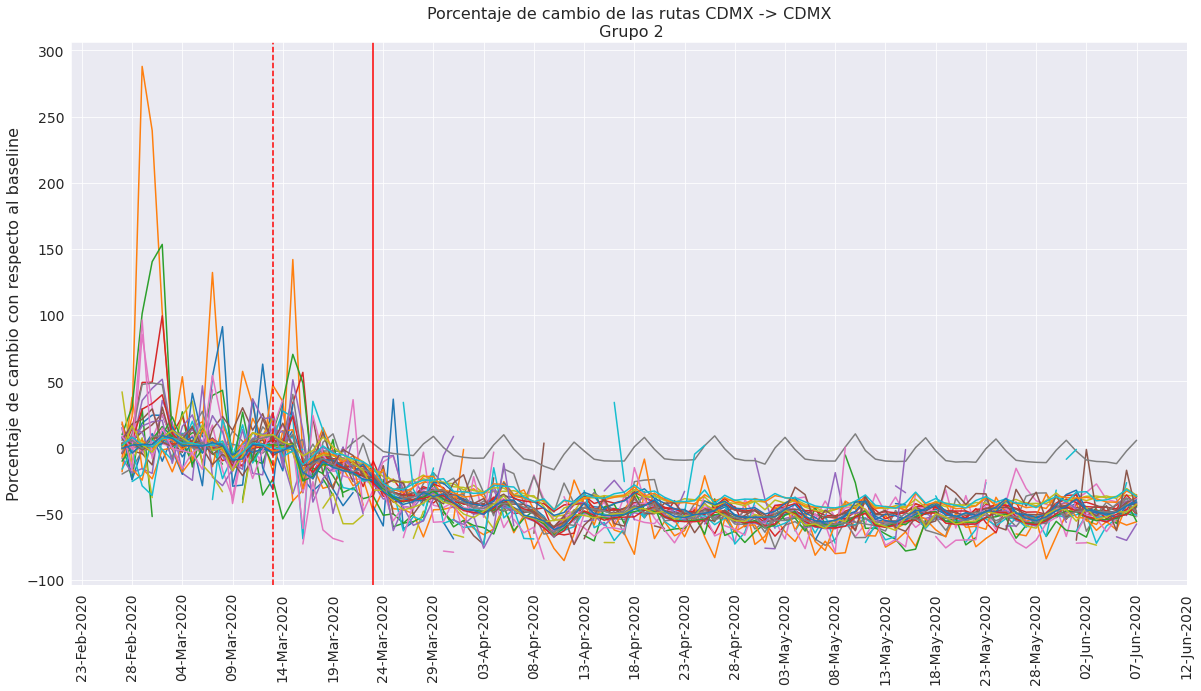

In [68]:
rutas = grupo2.index
dias = grupo2.columns

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo2.loc[ruta])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas CDMX -> CDMX\n Grupo 2', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()


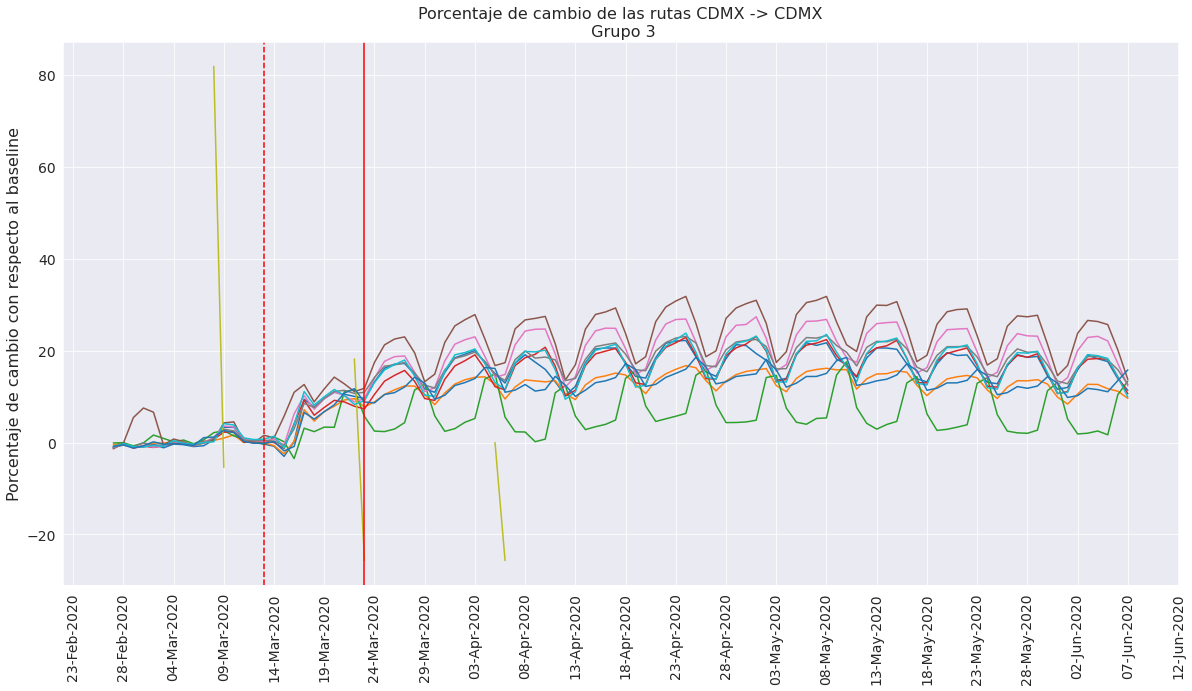

In [69]:
rutas = grupo3.index
dias = grupo3.columns

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo3.loc[ruta])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas CDMX -> CDMX\n Grupo 3', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

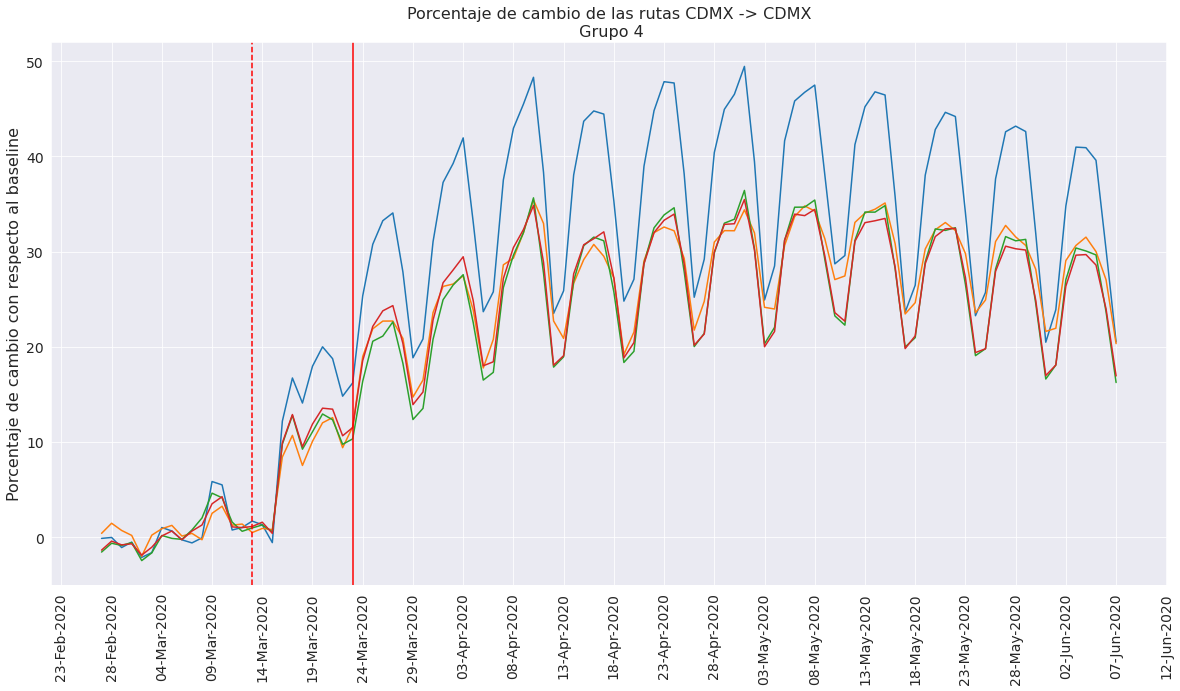

In [70]:
rutas = grupo4.index
dias = grupo4.columns

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

for ruta in rutas:
    ax.plot(grupo4.loc[ruta])

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas CDMX -> CDMX\n Grupo 4', fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()

Ruta Benito Juárez - Benito Juárez

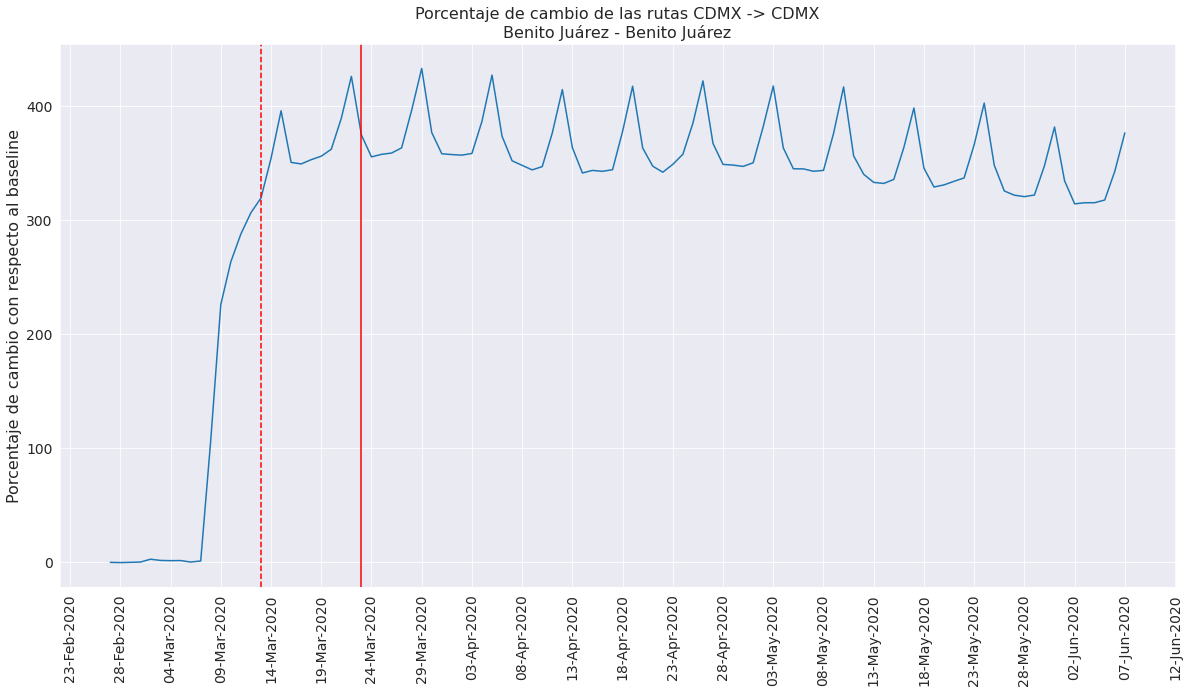

In [71]:
ruta = 'Benito Juárez - Benito Juárez'
rutas = cdmx_cdmx.loc[ruta]
dias = cdmx_cdmx.columns

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(rutas)

myFmt = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(DayLocator(interval=5))
#ax.xaxis.set_minor_formatter(myFmt)
ax.xaxis.set_minor_locator(DayLocator())

plt.title('Porcentaje de cambio de las rutas CDMX -> CDMX\n{}'.format(ruta), fontsize='16')
plt.ylabel('Porcentaje de cambio con respecto al baseline', fontsize='16')

plt.axvline(x=datetime.datetime(2020, 3, 23), color='red')
plt.axvline(x=datetime.datetime(2020, 3, 13), color='red', linestyle='dashed')

plt.xticks(fontsize='14', rotation='vertical')
plt.yticks(fontsize='14')
plt.show()



# Findings

De los datos:
   - Se tienen datos de 102 dias, desde 2020-02-27 al 2020-06-07, en ventanas de 8 horas.
   - Existen 5,433 registros repetidos de la base original de 284,495. Eliminados los repetidos, se tienen 279,062 registros restantes.
   - En el 0.14% de los casos, el baseline original de la base no es consistente, es decir, para ciertos dias se compara ocn un baseline distinto
    - Existen 1,571 rutas únicas en la base. Considerando las ventanas de tiempo, hay 1,438 ruta únicas a las 00 horas, 1,206 a las 08 horas y 1,316 las 16 horas.


De lo que podemos interpretar:
   - Las rutas con origen y destino fuera de la CDMX representan el 40% de las rutas en la base, mientras que las que tienen origen y destino en la CDMX son el 23.7%. 
   - La distribución de las rutas por hora, según su origen destino, se mantiene casi constante a lo largo de las 3 ventanas de tiempo para las rutas con origen y destino fuera de la CDMX.
   - Para las rutas con origen y destino en la CDMX, también se mantuvieron relativamente constantes a lo largo del día.
   - Las rutas con origen fuera de la CDMX y destino en la CDMX concentraron el 22% y 20% a las 8 y 16 horas, pero disminuyeron hasta 14% para las 00 horas. Inversamente, las rutas con origen en la CDMX y destino fuera de la CDMX aumentaron a 23% a las 00 horas, de 13% y 16% a las 8 y 6 horas.
   - En términos del número de personas que transitan las rutas el 95% se reparte entre rutas con origen y destino en la CDMX y, rutas con origen y destino fuera de la CDMX. El restante 5% de las personas que transitan, lo hace de municipios fuera de la CDMX a las alcaldías de la CDMX o viceversa.
   - Las 100 rutas más transitadas durante la “crisis” transportaron al 92% de las personas que  se movieron. Las principales rutas, nuevamente, se encontraron dentro de la CDMX y entre municipios fuera de la CDMX.
   - El 75.82% de las rutas tienen una longitud menor o igual a 20km
    


### Series de Tiempo

Ruta Benito Juárez - Benito Juárez

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

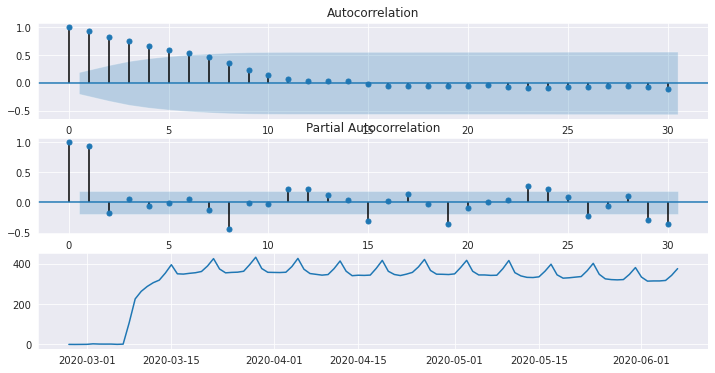

In [73]:
# Stationary data
rutas = cdmx_cdmx.loc['Benito Juárez - Benito Juárez']
#bj_bj = rutas - rutas.rolling(7).mean()

fig, ax = plt.subplots(3, figsize=(12,6))

x = rutas #(bj_bj.dropna() - bj_bj.dropna().shift(7)).dropna()

ax[0] = plot_acf(x, ax=ax[0], lags=30)
ax[1] = plot_pacf(x, ax=ax[1], lags=30)
ax[2].plot(x)

In [74]:
# Pearson correlation coefficient
#Compare the data with a lag=1 (or data(t) vs. data(t-1)) and a lag=2 (or data(t) vs. data(t-2).
shift_1 = rutas.autocorr(lag=1)
shift_2 = rutas.autocorr(lag=2)
print(shift_1, shift_2)

0.9622320699543285 0.9051701943726262


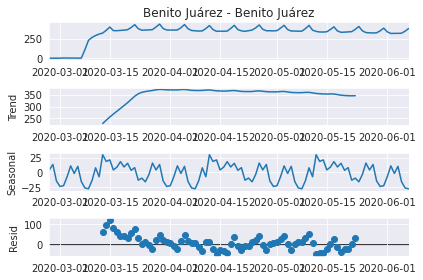

In [75]:
result = seasonal_decompose(rutas, model='additive', period=30)
result.plot()
plt.show()